In [197]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchvision import transforms as tfs
from torchvision.datasets import MNIST

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [198]:
device

'cuda'

In [200]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 4

train_dataloader =  DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
valid_dataloader =  DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

In [201]:
train_dataset.train_data.shape

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


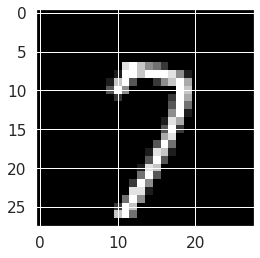

In [202]:
i = np.random.randint(low=0, high=60000)

plt.imshow(train_dataloader.dataset.test_data[i], cmap='gray')

In [203]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(400, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [204]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}
max_epochs = 10
accuracy = {"train": [], "valid": []}

In [205]:
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0

        for x_batch, y_batch in dataloader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                    outp = model(x_batch)

            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(outp)
            epoch_correct += correct.item()
            epoch_all += all

            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9584833333333334
Loader: valid. Accuracy: 0.9684
Epoch: 2
Loader: train. Accuracy: 0.9833166666666666
Loader: valid. Accuracy: 0.9794
Epoch: 3
Loader: train. Accuracy: 0.9874
Loader: valid. Accuracy: 0.9794
Epoch: 4
Loader: train. Accuracy: 0.9898833333333333
Loader: valid. Accuracy: 0.9849
Epoch: 5
Loader: train. Accuracy: 0.9909166666666667
Loader: valid. Accuracy: 0.9853
Epoch: 6
Loader: train. Accuracy: 0.9921166666666666
Loader: valid. Accuracy: 0.9861
Epoch: 7
Loader: train. Accuracy: 0.9927166666666667
Loader: valid. Accuracy: 0.987
Epoch: 8
Loader: train. Accuracy: 0.9931833333333333
Loader: valid. Accuracy: 0.9842
Epoch: 9
Loader: train. Accuracy: 0.9934666666666667
Loader: valid. Accuracy: 0.9734
Epoch: 10
Loader: train. Accuracy: 0.9938
Loader: valid. Accuracy: 0.9825


In [206]:
class_correct = np.zeros(10)
class_total = np.zeros(10)

with torch.no_grad():
    for data in valid_dataloader:
        images, labels = data
        y_pred = model(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        
        c = (predicted.cpu().detach() == labels)
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %2s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

Accuracy of  0 : 98 %
Accuracy of  1 : 99 %
Accuracy of  2 : 99 %
Accuracy of  3 : 98 %
Accuracy of  4 : 98 %
Accuracy of  5 : 98 %
Accuracy of  6 : 96 %
Accuracy of  7 : 95 %
Accuracy of  8 : 98 %
Accuracy of  9 : 98 %


In [207]:
def testModel(index=0):
    image = valid_dataloader.dataset.test_data[index]
    plt.imshow(image, cmap='gray')
    with torch.no_grad():
        model.eval()
        image = image.view(1, 1, 28, 28).to(torch.FloatTensor())
        y_pred = model(image.to(device))
        _, predicted = torch.max(y_pred, 1)
    print(f"Index: {index}")
    print(y_pred)
    print(f"Predicted value: {predicted[0]}\n\n")

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Index: 1991
tensor([[-16017.3477, -14308.7002,  -1139.8746, -13051.5938, -17712.0254,
         -25854.4590, -18706.9219, -15374.4873, -13886.6475, -19154.1875]],
       device='cuda:0')
Predicted value: 2




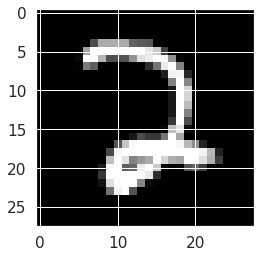

In [215]:
index = np.random.randint(low=0, high=10000)
testModel(index)